
# HFE Cool-Down Analysis

This notebook rebuilds the legacy closed-loop cool-down simulator for the HFE-7200 system using the measured HX performance data from `HX_performance_analysis.ipynb`. Goals:

- Fuse measured HX UA / heat-flux values with the physical tank + loop model from the depreciated script.
- Compare insulated vs bare plumbing while accounting for realistic ambient heat leak fits.
- Evaluate how mixing intensity and LN valve logic (manual vs auto) affect the timeline to reach 170 K and the LN consumption.
- Provide guidance on LN valve auto-mode hysteresis that prevents coil icing while still meeting the cooldown requirement.

Key inputs:

- `data/reports/hx_summary_windows_combined.csv` — UA / heat-flux medians for each dataset + time window.
- `data/reports/hx_heat_leak_20251023.txt` — ambient heat leak fit for t ≥ 20 min.
- Legacy geometry + material properties from the previous `HFE-7200 Closed-Loop Cool-Down Simulator — v3.4.1` script.



## Notebook roadmap

1. Load HX characterization tables and LN valve flow estimates created in `HX_performance_analysis.ipynb`.
2. Recreate the tank / loop geometry, masses, and heat leak channels, anchoring the model to the measured ambient heat leak fit.
3. Implement an updated lumped-parameter simulator that blends measured HX UA values with the original HFE thermo-physical properties.
4. Sweep across mixing intensities, insulation states, and LN valve policies (manual + auto) to quantify cooldown time and LN usage.
5. Explore LN valve auto hysteresis bands to recommend setpoints that limit icing while still hitting the 170 K target.


In [1]:

from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('ggplot')
sns.set_theme(style='whitegrid')


In [2]:
# Locate the repository root so the notebook can run from VS Code or Jupyter Lab
NB_PATH = Path.cwd()
REPO_ROOT = NB_PATH
for candidate in [NB_PATH, *NB_PATH.parents]:
    if (candidate / 'data').exists() and (candidate / 'analysis').exists():
        REPO_ROOT = candidate
        break

REPORTS_DIR = REPO_ROOT / 'data' / 'reports'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

full_summary_path = REPORTS_DIR / 'hx_full_summary_windows.csv'

summary_df = pd.read_csv(full_summary_path)

numeric_cols = [
    'samples',
    'slope_C_per_min',
    'slope_C_per_min_sigma',
    'P_HX_fit_W',
    'P_HX_fit_W_sigma',
    'UA_fit_W_per_K',
    'UA_fit_W_per_K_sigma',
    'heat_flux_fit_W_m2',
    'heat_flux_fit_W_m2_sigma',
    'UA_area_fit_W_per_m2K',
    'UA_area_fit_W_per_m2K_sigma',
    'DeltaT_mean_C',
    'r_squared',
]
summary_df[numeric_cols] = summary_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

WINDOW_SELECTION: Dict[str, str | None] = {
    'mixed': '5.0-20.0',
    'mixed_60psi': '2.0-8.0',
}

def select_summary_rows(df: pd.DataFrame, selection: Dict[str, str | None]) -> pd.DataFrame:
    rows = []
    for dataset, window in selection.items():
        subset = df[df['dataset'] == dataset]
        if window is not None:
            subset = subset[subset['window_min'] == window]
        if subset.empty:
            raise ValueError(f"Missing summary for dataset '{dataset}' window '{window}'.")
        rows.append(subset.iloc[0])
    return pd.DataFrame(rows).set_index('dataset')

per_dataset_summary = select_summary_rows(summary_df, WINDOW_SELECTION)
per_dataset_summary = per_dataset_summary.rename(index={
    'mixed': 'pump_recirculation_25psi',
    'mixed_60psi': 'pump_recirculation_60psi',
})
per_dataset_summary


,title,window_min,samples,slope_C_per_min,slope_C_per_min_sigma,P_HX_fit_W,P_HX_fit_W_sigma,UA_fit_W_per_K,UA_fit_W_per_K_sigma,heat_flux_fit_W_m2,heat_flux_fit_W_m2_sigma,UA_area_fit_W_per_m2K,UA_area_fit_W_per_m2K_sigma,DeltaT_mean_C,r_squared
dataset,,,,,,,,,,,,,,,
pump_recirculation_25psi,Mixed bath,5.0-20.0,896,-1.071255,0.001231,326.802714,0.357563,37.432017,0.040955,2723.355954,2.979694,311.933479,0.341294,8.730566,0.998821
pump_recirculation_60psi,Mixed bath — 60 psi LN (25 m/s outlet gas),2.0-8.0,347,-2.708779,0.004858,802.532082,1.411325,8.463448,0.014884,6687.767353,11.761045,70.528735,0.124031,94.823300,0.998892


In [3]:
ua_lookup = per_dataset_summary['UA_fit_W_per_K']
per_dataset_summary[['window_min', 'P_HX_fit_W', 'UA_fit_W_per_K', 'DeltaT_mean_C']]


,window_min,P_HX_fit_W,UA_fit_W_per_K,DeltaT_mean_C
dataset,,,,
pump_recirculation_25psi,5.0-20.0,326.802714,37.432017,8.730566
pump_recirculation_60psi,2.0-8.0,802.532082,8.463448,94.823300


In [4]:
PSI_TO_PA = 6_894.75729
LN_TUBING_ID_M = 3.87e-3
LN_TUBING_AREA_M2 = np.pi * (LN_TUBING_ID_M / 2.0) ** 2
LN_LIQUID_DENSITY_KG_M3 = 807.0

LN_FLOW_SCENARIOS = [
    {
        'key': 'baseline_25psi',
        'label': 'Baseline 25 psi (pump recirculation)',
        'pressure_psi': 25.0,
    },
    {
        'key': 'high_60psi',
        'label': '60 psi (pump recirculation)',
        'pressure_psi': 60.0,
        'measured_outlet_velocity_ms': 25.0,
    },
]

flow_rows = []
for scenario in LN_FLOW_SCENARIOS:
    pressure_pa = scenario['pressure_psi'] * PSI_TO_PA
    ideal_velocity = np.sqrt(2.0 * pressure_pa / LN_LIQUID_DENSITY_KG_M3)
    velocity_used = scenario.get('measured_outlet_velocity_ms', ideal_velocity)
    mass_flow_kg_s = LN_LIQUID_DENSITY_KG_M3 * LN_TUBING_AREA_M2 * velocity_used
    vol_flow_ml_s = mass_flow_kg_s / LN_LIQUID_DENSITY_KG_M3 * 1e6

    row = {
        'scenario': scenario['key'],
        'label': scenario['label'],
        'gauge_pressure_psi': scenario['pressure_psi'],
        'velocity_ms': velocity_used,
        'LN_mass_flow_g_s': mass_flow_kg_s * 1e3,
        'LN_vol_flow_mL_s': vol_flow_ml_s,
    }
    flow_rows.append(row)

ln_flow_df = pd.DataFrame(flow_rows)
ln_flow_df


,scenario,label,gauge_pressure_psi,velocity_ms,LN_mass_flow_g_s,LN_vol_flow_mL_s
0,baseline_25psi,Baseline 25 psi (pump recirculation),25.0,20.668441,196.197321,243.119356
1,high_60psi,60 psi (pump recirculation),60.0,25.000000,237.315090,294.070744


In [5]:
# Geometry from the legacy simulator (dimensions are already validated on hardware)
HEAT_LEAK_W = 15.5846  # W, measured during warm-up characterization (HX_performance_analysis)
T_REF_WARM_K = 278.2561715481171  # K, average bath temperature during the 6-10 min baseline window

PROC_LEN_M = 4.5
PROC_OD_M = 3.0 / 8.0 * 0.0254
PROC_WALL_M = 0.035 * 0.0254
PROC_ID_M = PROC_OD_M - 2 * PROC_WALL_M

TANK_H_M = 0.5
TANK_ID_M = 0.096
TANK_WALL_M = 0.0055

HX_LEN_M = 3.8
HX_OD_M = 0.25 * 0.0254
HX_WALL_M = 0.049 * 0.0254
HX_ID_M = HX_OD_M - 2 * HX_WALL_M
HX_AREA_M2 = 0.12  # from HX_performance_analysis

INS_THICK_M = 0.05
INS_K_W_MK = 0.03
K_STEEL = 16.0
H_AIR = 8.0
RHO_STEEL = 7_850.0
CP_STEEL = 500.0

T_AMB_K = 293.0
T_LN2_K = 77.0
TARGET_K = 170.0

HX_SEGMENTS = 50
HX_SEG_LEN_M = HX_LEN_M / HX_SEGMENTS
AREA_INNER = np.pi * HX_ID_M * HX_SEG_LEN_M
AREA_OUTER = np.pi * HX_OD_M * HX_SEG_LEN_M
R_WALL_SEG = np.log(HX_OD_M / HX_ID_M) / (2 * np.pi * K_STEEL * HX_SEG_LEN_M)

PROC_VOL_M3 = PROC_LEN_M * np.pi * (PROC_ID_M / 2) ** 2
TANK_VOL_M3 = np.pi * (TANK_ID_M / 2) ** 2 * TANK_H_M
TOTAL_VOL_M3 = PROC_VOL_M3 + TANK_VOL_M3

M_STEEL_KG = (
    np.pi * ((TANK_ID_M + 2 * TANK_WALL_M) ** 2 - TANK_ID_M ** 2) / 4 * TANK_H_M +
    np.pi * ((PROC_OD_M) ** 2 - PROC_ID_M ** 2) / 4 * PROC_LEN_M +
    np.pi * (HX_OD_M ** 2 - HX_ID_M ** 2) / 4 * HX_LEN_M
) * RHO_STEEL


STAGNANT_THICK_M = 0.015
K_HFE_LIQ = 0.065
R_HFE_STAGN_SEG = np.log((HX_OD_M / 2 + STAGNANT_THICK_M) / (HX_OD_M / 2)) / (
    2 * np.pi * K_HFE_LIQ * HX_SEG_LEN_M
)


def cyl_u(length_m: float, r_i_m: float, wall_m: float, h_inside_W_m2K: float, use_insulation: bool) -> float:
    """Overall UA per Kelvin for a cylinder section exchanging with ambient."""
    r_shell = r_i_m + wall_m
    a_inner = 2 * np.pi * r_i_m * length_m
    r_inner = 1.0 / (h_inside_W_m2K * a_inner)
    r_wall = np.log(r_shell / r_i_m) / (2 * np.pi * K_STEEL * length_m)
    if use_insulation:
        r_outer = r_shell + INS_THICK_M
        r_ins = np.log(r_outer / r_shell) / (2 * np.pi * INS_K_W_MK * length_m)
        r_out = 1.0 / (H_AIR * 2 * np.pi * r_outer * length_m)
        r_total = r_inner + r_wall + r_ins + r_out
    else:
        r_out = 1.0 / (H_AIR * 2 * np.pi * r_shell * length_m)
        r_total = r_inner + r_wall + r_out
    return 1.0 / r_total

C_AMB_TANK_INS = cyl_u(TANK_H_M, TANK_ID_M / 2, TANK_WALL_M, 150.0, True)
C_AMB_LOOP_INS = cyl_u(PROC_LEN_M, PROC_ID_M / 2, PROC_WALL_M, 150.0, True)
C_AMB_TANK_BARE = cyl_u(TANK_H_M, TANK_ID_M / 2, TANK_WALL_M, 150.0, False)
C_AMB_LOOP_BARE = cyl_u(PROC_LEN_M, PROC_ID_M / 2, PROC_WALL_M, 150.0, False)

C_AMB_INS_GEOM = C_AMB_TANK_INS + C_AMB_LOOP_INS
C_AMB_BARE_GEOM = C_AMB_TANK_BARE + C_AMB_LOOP_BARE

# Anchor the leak coefficient to the measured value around 5 °C and scale using the geometric ratio
C_LEAK_INS_MEAS = HEAT_LEAK_W / max(T_AMB_K - T_REF_WARM_K, 1e-6)
LEAK_SCALE = C_LEAK_INS_MEAS / C_AMB_INS_GEOM
LEAK_COEFFS = {
    'insulated': C_AMB_INS_GEOM * LEAK_SCALE,
    'bare': C_AMB_BARE_GEOM * LEAK_SCALE,
}

TOTAL_VOL_M3, M_STEEL_KG, LEAK_COEFFS


(0.0038312288215291428,
 8.331129116190928,
 {'insulated': 1.0570253208561797, 'bare': 5.168246494999909})

In [6]:
# Convert UA measured with the glycol antifreeze bath to an expected UA for HFE-7200
# using a Dittus–Boelter convection estimate on the bath side and scaling the LN-side
# resistance by mass-flow rate.

ANTIFREEZE_PROPS = {
    'rho_kg_m3': 1_085.0,   # kg/m³
    'mu_Pa_s': 3.5e-3,      # Pa·s
    'cp_J_kgK': 2_840.0,    # J/(kg·K)
    'k_W_mK': 0.36,         # W/(m·K)
}

HFE7200_PROPS = {
    'rho_kg_m3': 1_420.0,
    'mu_Pa_s': 0.61e-3,
    'cp_J_kgK': 1_200.0,
    'k_W_mK': 0.065,
}

ANTIFREEZE_TEST = {
    'flow_lpm': 2.0,               # loop flow used during the antifreeze test
    'UA_total_W_per_K': 300.0,     # measured UA with the glycol mix
}


def dittus_boelter_h(flow_lpm: float, diameter_m: float, props: dict) -> dict:
    flow_m3_s = flow_lpm / 60_000.0
    area_m2 = np.pi * (diameter_m / 2.0) ** 2
    velocity_ms = flow_m3_s / max(area_m2, 1e-12)
    reynolds = props['rho_kg_m3'] * velocity_ms * diameter_m / max(props['mu_Pa_s'], 1e-12)
    prandtl = props['cp_J_kgK'] * props['mu_Pa_s'] / max(props['k_W_mK'], 1e-12)
    nu = 0.023 * (reynolds ** 0.8) * (prandtl ** 0.4)
    h_W_m2K = nu * props['k_W_mK'] / max(diameter_m, 1e-12)
    return {
        'h_W_m2K': h_W_m2K,
        'Re': reynolds,
        'Pr': prandtl,
        'Nu': nu,
        'velocity_ms': velocity_ms,
    }

antifreeze_ht = dittus_boelter_h(ANTIFREEZE_TEST['flow_lpm'], HX_ID_M, ANTIFREEZE_PROPS)
hfe_ht = dittus_boelter_h(ANTIFREEZE_TEST['flow_lpm'], HX_ID_M, HFE7200_PROPS)

UA_bath_antifreeze_W_per_K = antifreeze_ht['h_W_m2K'] * HX_AREA_M2
UA_bath_hfe_W_per_K = hfe_ht['h_W_m2K'] * HX_AREA_M2

UA_total_antifreeze = ANTIFREEZE_TEST['UA_total_W_per_K']
if UA_bath_antifreeze_W_per_K <= UA_total_antifreeze:
    raise ValueError('Bath-side UA cannot be lower than the measured total UA; check inputs.')

UA_LN_baseline_W_per_K = 1.0 / (1.0 / UA_total_antifreeze - 1.0 / UA_bath_antifreeze_W_per_K)

ua_rows = []
baseline_mass_flow = None
for row in ln_flow_df.itertuples():
    if row.scenario == 'baseline_25psi':
        baseline_mass_flow = row.LN_mass_flow_g_s
        break

if baseline_mass_flow is None:
    raise ValueError('baseline_25psi scenario required in ln_flow_df for UA conversion.')

for row in ln_flow_df.itertuples():
    mass_flow_ratio = row.LN_mass_flow_g_s / baseline_mass_flow
    ua_ln_W_per_K = UA_LN_baseline_W_per_K * mass_flow_ratio
    ua_total_hfe_W_per_K = 1.0 / (1.0 / UA_bath_hfe_W_per_K + 1.0 / ua_ln_W_per_K)
    ua_rows.append({
        'scenario': row.scenario,
        'LN_mass_flow_g_s': row.LN_mass_flow_g_s,
        'UA_total_HFE_W_per_K': ua_total_hfe_W_per_K,
        'UA_LN_W_per_K': ua_ln_W_per_K,
        'UA_bath_HFE_W_per_K': UA_bath_hfe_W_per_K,
    })

ua_conversion_df = pd.DataFrame(ua_rows).set_index('scenario')
ua_conversion_df = ua_conversion_df.round({
    'LN_mass_flow_g_s': 1,
    'UA_total_HFE_W_per_K': 1,
    'UA_LN_W_per_K': 1,
    'UA_bath_HFE_W_per_K': 1,
})
ua_conversion_df

UA_PUMP_RECIRC_25_W_PER_K = float(ua_conversion_df.loc['baseline_25psi', 'UA_total_HFE_W_per_K'])
UA_PUMP_RECIRC_60_W_PER_K = float(ua_conversion_df.loc['high_60psi', 'UA_total_HFE_W_per_K'])
ua_conversion_df

,LN_mass_flow_g_s,UA_total_HFE_W_per_K,UA_LN_W_per_K,UA_bath_HFE_W_per_K
scenario,,,,
baseline_25psi,196.2,236.6,557.1,411.4
high_60psi,237.3,255.4,673.9,411.4


In [7]:
def lpm_to_m3s(flow_lpm: float) -> float:
    return flow_lpm / 60_000.0


def rho_hfe(T_K: float) -> float:
    return max(1050.0, 1_420.0 - 2.9 * (T_K - 298.0))


def cp_hfe(T_K: float) -> float:
    return max(900.0, 1_220.0 + 1.5 * (T_K - 298.0))


H_FG_LN2_J_KG = 1.99e5
SIM_DURATION_H = 6.0
STOP_AFTER_TARGET = True
MAX_DT_S = 5.0
MIN_DT_S = 0.5


In [8]:

@dataclass
class ValvePolicy:
    key: str
    label: str
    ua_open_W_per_K: float
    ua_closed_W_per_K: float
    open_above_K: float = -np.inf
    close_below_K: float = -np.inf
    hysteresis_K: float = 0.0
    notes: str = ''

    def should_be_open(self, temp_K: float, currently_open: bool) -> bool:
        if np.isinf(self.open_above_K) and np.isinf(self.close_below_K):
            return True
        if currently_open and temp_K <= self.close_below_K:
            return False
        if (not currently_open) and temp_K >= self.open_above_K:
            return True
        return currently_open

    def ua(self, open_state: bool) -> float:
        return self.ua_open_W_per_K if open_state else self.ua_closed_W_per_K


@dataclass
class CooldownScenario:
    key: str
    label: str
    valve_policy: ValvePolicy
    hfe_flow_lpm: float
    ln_flow_key: str
    description: str = ''


In [9]:
ln_flow_lookup = ln_flow_df.set_index('scenario')


def simulate_cooldown(scenario: CooldownScenario, insulation_key: str) -> Dict[str, np.ndarray]:
    leak_coeff = LEAK_COEFFS[insulation_key]
    ln_row = ln_flow_lookup.loc[scenario.ln_flow_key]
    ln_mass_flow_kg_s = ln_row['LN_mass_flow_g_s'] / 1_000.0

    dt_s = np.clip(TOTAL_VOL_M3 / max(lpm_to_m3s(scenario.hfe_flow_lpm), 1e-6), MIN_DT_S, MAX_DT_S)
    total_steps = int(SIM_DURATION_H * 3600 / dt_s)

    temp_K = 298.0
    valve_open = True

    time_s = np.zeros(total_steps + 1)
    temp_trace = np.zeros_like(time_s)
    hx_power = np.zeros_like(time_s)
    leak_power = np.zeros_like(time_s)
    ua_trace = np.zeros_like(time_s)
    valve_trace = np.zeros_like(time_s)

    time_s[0] = 0.0
    temp_trace[0] = temp_K
    ua_trace[0] = scenario.valve_policy.ua(True)
    valve_trace[0] = 1.0

    hit_time_min = np.nan
    ln_used_kg = 0.0
    last_idx = 0

    for idx in range(1, total_steps + 1):
        valve_open = scenario.valve_policy.should_be_open(temp_K, valve_open)
        ua = scenario.valve_policy.ua(valve_open)

        q_hx = ua * max(temp_K - T_LN2_K, 0.0)
        q_lat_max = (ln_mass_flow_kg_s if valve_open else 0.0) * H_FG_LN2_J_KG
        q_removed = min(q_hx, q_lat_max)
        q_gained = leak_coeff * (T_AMB_K - temp_K)

        m_hfe = TOTAL_VOL_M3 * rho_hfe(temp_K)
        c_total = m_hfe * cp_hfe(temp_K) + M_STEEL_KG * CP_STEEL
        temp_K += (q_gained - q_removed) * dt_s / c_total

        if q_removed > 0.0:
            ln_used_kg += q_removed * dt_s / H_FG_LN2_J_KG

        if np.isnan(hit_time_min) and temp_K <= TARGET_K:
            hit_time_min = idx * dt_s / 60.0
            if STOP_AFTER_TARGET:
                last_idx = idx
                time_s[idx] = idx * dt_s
                temp_trace[idx] = temp_K
                hx_power[idx] = q_removed
                leak_power[idx] = q_gained
                ua_trace[idx] = ua
                valve_trace[idx] = 1.0 if valve_open else 0.0
                break

        time_s[idx] = idx * dt_s
        temp_trace[idx] = temp_K
        hx_power[idx] = q_removed
        leak_power[idx] = q_gained
        ua_trace[idx] = ua
        valve_trace[idx] = 1.0 if valve_open else 0.0
        last_idx = idx

    slice_end = last_idx + 1
    time_s = time_s[:slice_end]
    temp_trace = temp_trace[:slice_end]
    hx_power = hx_power[:slice_end]
    leak_power = leak_power[:slice_end]
    ua_trace = ua_trace[:slice_end]
    valve_trace = valve_trace[:slice_end]

    valve_open_frac = float(np.mean(valve_trace)) if valve_trace.size else 0.0

    result = {
        'scenario': scenario,
        'insulation': insulation_key,
        'time_s': time_s,
        'temp_K': temp_trace,
        'hx_power_W': hx_power,
        'leak_power_W': leak_power,
        'ua_W_per_K': ua_trace,
        'valve_state': valve_trace,
        'valve_open_frac': valve_open_frac,
        'time_to_target_min': hit_time_min,
        'ln_used_kg': ln_used_kg,
    }
    return result


In [10]:
UA_PUMP_RECIRC_25 = float(UA_PUMP_RECIRC_25_W_PER_K)
UA_PUMP_RECIRC_60 = float(UA_PUMP_RECIRC_60_W_PER_K)

valve_policies = {
    'pump_recirculation_25psi': ValvePolicy(
        key='pump_recirculation_25psi',
        label='Pump recirculation (25 psi LN)',
        ua_open_W_per_K=UA_PUMP_RECIRC_25,
        ua_closed_W_per_K=UA_PUMP_RECIRC_25,
        notes='HFE-7200 bath; UA derived from 300 W/K antifreeze test with mixed-side scaling.'
    ),
    'pump_recirculation_60psi': ValvePolicy(
        key='pump_recirculation_60psi',
        label='Pump recirculation (60 psi LN)',
        ua_open_W_per_K=UA_PUMP_RECIRC_60,
        ua_closed_W_per_K=UA_PUMP_RECIRC_60,
        notes='Same bath-side UA, LN-side scaled with mass flow.'
    ),
}

scenarios = [
    CooldownScenario(
        key='pump_recirculation_25psi',
        label='Pump recirculation — 25 psi',
        valve_policy=valve_policies['pump_recirculation_25psi'],
        hfe_flow_lpm=2.0,
        ln_flow_key='baseline_25psi',
        description='Nominal circulation pump mixing with 25 psi LN supply.'
    ),
    CooldownScenario(
        key='pump_recirculation_60psi',
        label='Pump recirculation — 60 psi',
        valve_policy=valve_policies['pump_recirculation_60psi'],
        hfe_flow_lpm=2.0,
        ln_flow_key='high_60psi',
        description='Pump mixing with elevated LN pressure test (60 psi).'
    ),
]

scenarios


[CooldownScenario(key='pump_recirculation_25psi', label='Pump recirculation — 25 psi', valve_policy=ValvePolicy(key='pump_recirculation_25psi', label='Pump recirculation (25 psi LN)', ua_open_W_per_K=236.6, ua_closed_W_per_K=236.6, open_above_K=-inf, close_below_K=-inf, hysteresis_K=0.0, notes='HFE-7200 bath; UA derived from 300 W/K antifreeze test with mixed-side scaling.'), hfe_flow_lpm=2.0, ln_flow_key='baseline_25psi', description='Nominal circulation pump mixing with 25 psi LN supply.'),
 CooldownScenario(key='pump_recirculation_60psi', label='Pump recirculation — 60 psi', valve_policy=ValvePolicy(key='pump_recirculation_60psi', label='Pump recirculation (60 psi LN)', ua_open_W_per_K=255.4, ua_closed_W_per_K=255.4, open_above_K=-inf, close_below_K=-inf, hysteresis_K=0.0, notes='Same bath-side UA, LN-side scaled with mass flow.'), hfe_flow_lpm=2.0, ln_flow_key='high_60psi', description='Pump mixing with elevated LN pressure test (60 psi).')]

In [11]:
results = []
for scenario in scenarios:
    for insulation_key in LEAK_COEFFS:
        sim = simulate_cooldown(scenario, insulation_key)
        results.append(sim)

summary_rows = []
for sim in results:
    time_s = sim['time_s']
    temp_K = sim['temp_K']
    ln_used_kg = sim['ln_used_kg']
    hx_power = sim['hx_power_W']

    positive_power = hx_power[hx_power > 0.0]
    avg_power = float(np.mean(positive_power)) if positive_power.size else 0.0
    peak_power = float(np.max(hx_power)) if hx_power.size else 0.0
    cooldown_duration_min = float(time_s[-1] / 60.0) if time_s.size else float('nan')

    summary_rows.append({
        'scenario': sim['scenario'].key,
        'label': sim['scenario'].label,
        'insulation': sim['insulation'],
        'cooldown_duration_min': cooldown_duration_min,
        'time_to_170_min': sim['time_to_target_min'],
        'final_temp_K': temp_K[-1] if temp_K.size else float('nan'),
        'final_temp_C': (temp_K[-1] - 273.15) if temp_K.size else float('nan'),
        'ln_used_kg': ln_used_kg,
        'ln_used_L': ln_used_kg / LN_LIQUID_DENSITY_KG_M3 * 1_000.0,
        'valve_open_frac': sim.get('valve_open_frac', float(np.mean(sim['valve_state']))),
        'avg_hx_power_W': avg_power,
        'peak_hx_power_W': peak_power,
    })

summary_df_out = pd.DataFrame(summary_rows)
summary_df_out


,scenario,label,insulation,cooldown_duration_min,time_to_170_min,final_temp_K,final_temp_C,ln_used_kg,ln_used_L,valve_open_frac,avg_hx_power_W,peak_hx_power_W
0,pump_recirculation_25psi,Pump recirculation — 25 psi,insulated,0.750000,0.750000,162.653722,-110.496278,7.523056,9.322251,1.0,33268.627013,39043.266818
1,pump_recirculation_25psi,Pump recirculation — 25 psi,bare,0.750000,0.750000,163.468450,-109.681550,7.535015,9.337070,1.0,33321.511356,39043.266818
2,pump_recirculation_60psi,Pump recirculation — 60 psi,insulated,0.666667,0.666667,162.650040,-110.499960,7.518720,9.316877,1.0,37405.630613,47225.702965
3,pump_recirculation_60psi,Pump recirculation — 60 psi,bare,0.666667,0.666667,163.387527,-109.762473,7.529269,9.329950,1.0,37458.114916,47225.702965


In [12]:
# Optional manual x-axis limits (minutes) per plumbing case.
# Set to a float to enforce a maximum, or leave as None for full simulation span.
PLOT_TIME_MAX_MIN = {
    'insulated': 4,
    'bare': 4,
}


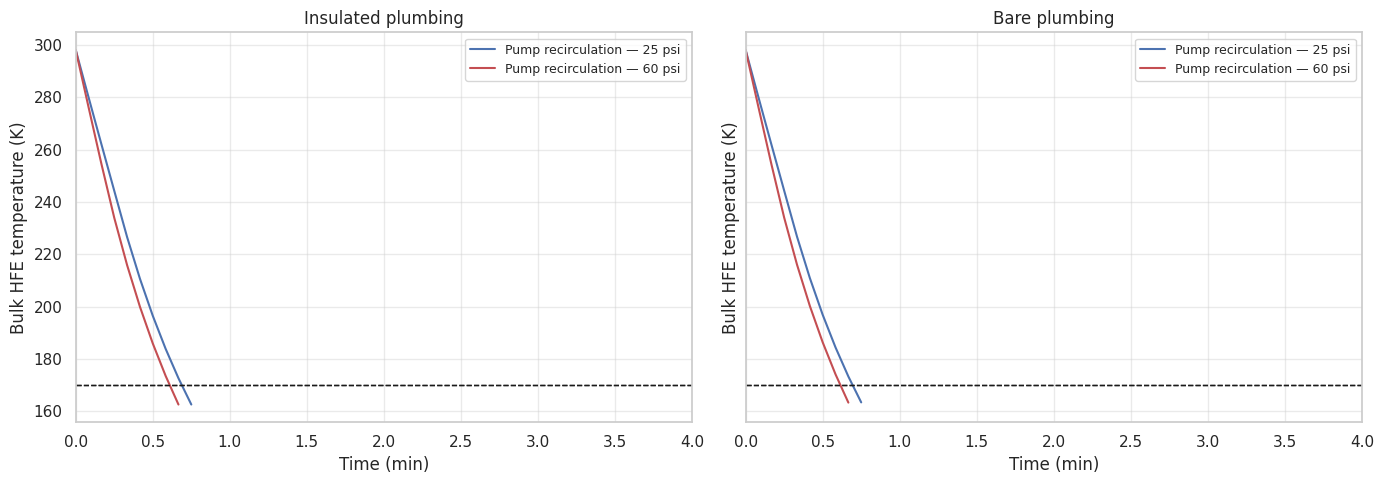

In [13]:
color_map = {
    'pump_recirculation_25psi': 'C0',
    'pump_recirculation_60psi': 'C3',
}

max_time_by_insulation = {'insulated': 0.0, 'bare': 0.0}

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for sim in results:
    insulation = sim['insulation']
    idx = 0 if insulation == 'insulated' else 1
    times_min = sim['time_s'] / 60.0
    axes[idx].plot(times_min, sim['temp_K'], color=color_map.get(sim['scenario'].key, 'k'), label=sim['scenario'].label)
    axes[idx].set_title(f"{insulation.capitalize()} plumbing")
    axes[idx].axhline(TARGET_K, color='k', ls='--', lw=1)
    axes[idx].set_xlabel('Time (min)')
    axes[idx].set_ylabel('Bulk HFE temperature (K)')
    axes[idx].grid(True, alpha=0.4)

    max_time_by_insulation[insulation] = max(max_time_by_insulation[insulation], float(times_min[-1]))


def resolve_plot_xlim(insulation: str) -> float | None:
    if isinstance(PLOT_TIME_MAX_MIN, dict):
        return PLOT_TIME_MAX_MIN.get(insulation)
    return PLOT_TIME_MAX_MIN

for ax, insulation in zip(axes, ['insulated', 'bare']):
    t_max = resolve_plot_xlim(insulation)
    if t_max is None:
        t_max = max_time_by_insulation.get(insulation, 0.0)
    ax.set_xlim(0, t_max)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=9)

plt.tight_layout()
plt.show()


## Automatisation

Auto-valve threshold sweep not studied yet. Make heatmap of Time to temperature vs automatisation rate & dewar pressure; LN consumed (kg) vs automatisation & dewar pressure.